In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth


%%capture
!pip install --no-deps --upgrade transformers
!pip install --no-deps --upgrade timm



In [2]:
import gc
from unsloth import FastModel
import torch
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directories for results
os.makedirs('results/translation', exist_ok=True)
os.makedirs('plots/translation', exist_ok=True)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# Install required packages for translation metrics
!pip install -q nltk==3.8.1 rouge-score==0.1.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.


In [4]:


import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download punkt tokenizer
nltk.download('punkt', quiet=True)

True

In [5]:
def load_model_and_tokenizer(model_id, is_unsloth=False):
    """Load model with appropriate method"""
    if is_unsloth:
        model, processor = FastModel.from_pretrained(
            model_name=model_id,
            dtype=None,
            max_seq_length=2048,
            load_in_4bit=False,
        )

        # Extract the tokenizer from the processor
        tokenizer = processor.tokenizer
        print(f"Extracted tokenizer of type: {type(tokenizer).__name__}")

        # Ensure we have pad token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer
    else:
        print(f"Loading {model_id} in full precision")
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            trust_remote_code=True,
        )
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            trust_remote_code=True,
        )

        # Ensure we have pad token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer

@torch.no_grad()
def calculate_perplexity(model, tokenizer, prompt, target, max_length=512):
    """Calculate perplexity of target given prompt"""
    # Combine prompt and target
    full_text = f"{prompt}\n{target}"

    # Tokenize
    inputs = tokenizer(full_text, return_tensors="pt", truncation=True, max_length=max_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get the position where target starts
    prompt_tokens = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length)
    prompt_length = prompt_tokens.input_ids.shape[1]

    # Forward pass
    outputs = model(**inputs)
    logits = outputs.logits

    # Calculate loss only on target tokens
    shift_logits = logits[..., prompt_length-1:-1, :].contiguous()
    shift_labels = inputs['input_ids'][..., prompt_length:].contiguous()

    # Calculate cross entropy
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    # Calculate perplexity
    perplexity = torch.exp(loss.mean()).item()

    return perplexity

@torch.no_grad()
def score_translations(model, tokenizer, sources, references, prompt_template, verbose=True):
    """Score translations using perplexity"""
    perplexities = []
    total = len(sources)

    for i, (source, reference) in enumerate(zip(sources, references)):
        prompt = prompt_template.format(src=source)

        try:
            perplexity = calculate_perplexity(model, tokenizer, prompt, reference)
            perplexities.append(perplexity)
        except Exception as e:
            print(f"Warning: Failed to calculate perplexity for example {i+1}: {e}")
            perplexities.append(float('inf'))

        if verbose and (i + 1) % 50 == 0:
            print(f"Progress: {i+1}/{total} scored (avg perplexity: {np.mean([p for p in perplexities if p != float('inf')]):.2f})")

    return perplexities

def calculate_metrics_from_perplexity(perplexities):
    """Calculate metrics from perplexity scores"""
    # Filter out infinite values
    valid_perplexities = [p for p in perplexities if p != float('inf')]

    if not valid_perplexities:
        return {
            'avg_perplexity': float('inf'),
            'median_perplexity': float('inf'),
            'perplexity_score': 0.0  # 0-100 score
        }

    avg_perplexity = np.mean(valid_perplexities)
    median_perplexity = np.median(valid_perplexities)

    # Convert to a 0-100 score (lower perplexity is better)
    # Using a sigmoid-like transformation
    perplexity_score = 100 * np.exp(-avg_perplexity / 100)

    return {
        'avg_perplexity': avg_perplexity,
        'median_perplexity': median_perplexity,
        'perplexity_score': perplexity_score,
        'valid_examples': len(valid_perplexities),
        'total_examples': len(perplexities)
    }

# For backward compatibility, let's also implement a generation approach with better prompting
@torch.no_grad()
def generate_translation_improved(prompt, model, tokenizer, max_new_tokens=128):
    """Generate translation with improved prompting"""
    # Use chat template if available
    try:
        messages = [{"role": "user", "content": prompt}]
        inputs = tokenizer.apply_chat_template(
            messages,
            return_tensors="pt",
            add_generation_prompt=True
        ).to(model.device)

        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        # Decode only the generated part
        generated = tokenizer.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True)
        return generated.strip()

    except:
        # Fallback to simple generation
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract translation after the prompt
        if prompt in generated_text:
            translation = generated_text.split(prompt)[-1].strip()
        else:
            translation = generated_text.strip()

        return translation

In [6]:
# Load dataset
DATASET_NAME = "emuchogu/swahili-english-translation"
SAMPLE_SIZE = 50  # Total samples (will be split roughly equally between directions)
SEED = 42

print(f"Loading dataset: {DATASET_NAME}")
raw_dataset = load_dataset(DATASET_NAME, split="train")
print(f"Total examples in dataset: {len(raw_dataset)}")
print(f"Total benchmarking examples i: {SAMPLE_SIZE}")

# Sample and shuffle with seed for reproducibility
sampled_data = raw_dataset.shuffle(seed=SEED).select(range(min(SAMPLE_SIZE, len(raw_dataset))))

# Split into EN→SW and SW→EN based on odd/even indices
en_to_sw_data = []
sw_to_en_data = []

for idx, example in enumerate(sampled_data):
    if (idx + 1) % 2 == 1:  # Odd indices for EN→SW
        en_to_sw_data.append({
            'source': example['input'].strip(),
            'reference': example['output'].strip()
        })
    else:  # Even indices for SW→EN
        sw_to_en_data.append({
            'source': example['input'].strip(),
            'reference': example['output'].strip()
        })

print(f"\nDataset split:")
print(f"  EN→SW: {len(en_to_sw_data)} examples")
print(f"  SW→EN: {len(sw_to_en_data)} examples")

# Show sample examples
print("\nSample EN→SW:")
if en_to_sw_data:
    print(f"  Source: {en_to_sw_data[0]['source']}")
    print(f"  Reference: {en_to_sw_data[0]['reference']}")

print("\nSample SW→EN:")
if sw_to_en_data:
    print(f"  Source: {sw_to_en_data[0]['source']}")
    print(f"  Reference: {sw_to_en_data[0]['reference']}")

Loading dataset: emuchogu/swahili-english-translation


README.md:   0%|          | 0.00/353 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/70.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1115700 [00:00<?, ? examples/s]

Total examples in dataset: 1115700
Total benchmarking examples i: 50

Dataset split:
  EN→SW: 25 examples
  SW→EN: 25 examples

Sample EN→SW:
  Source: Mchezaji wa kuteleza kwenye theluji anachukua njia ya mteremko chini ya mlima.
  Reference: Skier takes a steep path down the mountain.

Sample SW→EN:
  Source: Jiji Takatifu lilibaki kuwa mahali pa kutoroka hadi karne ya 19, wakati upendezi uliorudiwa kati ya Wakristo waliohama ulifanya kuwa mahali pa maelfu ya wasafiri kila mwaka.
  Reference: The Holy City remained a backwater until the 19th century, when renewed interest among Christian pilgrims made it the destination of thousands of travelers each year.


In [7]:
# Define models with proper naming
MODEL_CONFIG = {
    "gemma-3n-swahili-E2B-it": {
        "id": "Nadhari/gemma-3n-swahili-E2B-it",
        "is_unsloth": False
    },
    "gemma-3n-swahili-E4B-it": {
        "id": "Nadhari/gemma-3n-swahili-E4B-it",
        "is_unsloth": False
    },
    "gemma-3n-E2B-it": {
        "id": "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
        "is_unsloth": True
    },
    "gemma-3n-E4B-it": {
        "id": "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
        "is_unsloth": True
    },
}

# Define translation prompts - let's try better prompts
PROMPTS = {
    'en_to_sw': 'Translate this sentence from English to Swahili:\n\n{src}\n\nSwahili translation:',
    'sw_to_en': 'Translate this sentence from Swahili to English:\n\n{src}\n\nEnglish translation:'
}

# Alternative Swahili prompts
PROMPTS_SW = {
    'en_to_sw': 'Tafsiri sentensi hii kutoka Kiingereza hadi Kiswahili:\n\n{src}\n\nTafsiri ya Kiswahili:',
    'sw_to_en': 'Tafsiri sentensi hii kutoka Kiswahili hadi Kiingereza:\n\n{src}\n\nTafsiri ya Kiingereza:'
}

# Run evaluation for each model
all_results = {}

for model_name, config in MODEL_CONFIG.items():
    print(f"\n{'='*70}")
    print(f"🔄 Evaluating: {model_name}")
    print(f"   Model ID: {config['id']}")
    print(f"   Type: {'Unsloth' if config['is_unsloth'] else 'HuggingFace'}")
    print(f"{'='*70}")

    try:
        # Load model
        start_time = datetime.now()
        model, tokenizer = load_model_and_tokenizer(
            config['id'],
            is_unsloth=config['is_unsloth']
        )
        model.eval()

        results = {
            'model_name': model_name,
            'model_id': config['id'],
            'timestamp': datetime.now().isoformat()
        }

        # Decide which prompts to use based on model name
        prompts_to_use = PROMPTS_SW if 'swahili' in model_name.lower() else PROMPTS

        # English to Swahili evaluation using perplexity
        print(f"\n📝 Scoring EN→SW translations ({len(en_to_sw_data)} examples)...")
        en_sources = [item['source'] for item in en_to_sw_data]
        sw_references = [item['reference'] for item in en_to_sw_data]

        en_sw_perplexities = score_translations(
            model, tokenizer,
            en_sources, sw_references,
            prompts_to_use['en_to_sw'],
            verbose=True
        )

        en_sw_metrics = calculate_metrics_from_perplexity(en_sw_perplexities)

        # Store example with lowest perplexity (best) and highest (worst)
        valid_indices = [(i, p) for i, p in enumerate(en_sw_perplexities) if p != float('inf')]
        if valid_indices:
            valid_indices.sort(key=lambda x: x[1])
            best_idx = valid_indices[0][0]
            worst_idx = valid_indices[-1][0]

            example_translations = [
                {
                    'type': 'best',
                    'source': en_sources[best_idx],
                    'reference': sw_references[best_idx],
                    'perplexity': en_sw_perplexities[best_idx]
                },
                {
                    'type': 'worst',
                    'source': en_sources[worst_idx],
                    'reference': sw_references[worst_idx],
                    'perplexity': en_sw_perplexities[worst_idx]
                }
            ]
        else:
            example_translations = []

        results['en_to_sw'] = {
            'avg_perplexity': en_sw_metrics['avg_perplexity'],
            'median_perplexity': en_sw_metrics['median_perplexity'],
            'perplexity_score': en_sw_metrics['perplexity_score'],
            'num_examples': len(en_to_sw_data),
            'valid_examples': en_sw_metrics['valid_examples'],
            'example_translations': example_translations
        }

        print(f"✅ EN→SW - Avg Perplexity: {en_sw_metrics['avg_perplexity']:.2f}, Score: {en_sw_metrics['perplexity_score']:.2f}/100")

        # Swahili to English evaluation
        print(f"\n📝 Scoring SW→EN translations ({len(sw_to_en_data)} examples)...")
        sw_sources = [item['source'] for item in sw_to_en_data]
        en_references = [item['reference'] for item in sw_to_en_data]

        sw_en_perplexities = score_translations(
            model, tokenizer,
            sw_sources, en_references,
            prompts_to_use['sw_to_en'],
            verbose=True
        )

        sw_en_metrics = calculate_metrics_from_perplexity(sw_en_perplexities)

        # Store best/worst examples
        valid_indices = [(i, p) for i, p in enumerate(sw_en_perplexities) if p != float('inf')]
        if valid_indices:
            valid_indices.sort(key=lambda x: x[1])
            best_idx = valid_indices[0][0]
            worst_idx = valid_indices[-1][0]

            example_translations_sw = [
                {
                    'type': 'best',
                    'source': sw_sources[best_idx],
                    'reference': en_references[best_idx],
                    'perplexity': sw_en_perplexities[best_idx]
                },
                {
                    'type': 'worst',
                    'source': sw_sources[worst_idx],
                    'reference': en_references[worst_idx],
                    'perplexity': sw_en_perplexities[worst_idx]
                }
            ]
        else:
            example_translations_sw = []

        results['sw_to_en'] = {
            'avg_perplexity': sw_en_metrics['avg_perplexity'],
            'median_perplexity': sw_en_metrics['median_perplexity'],
            'perplexity_score': sw_en_metrics['perplexity_score'],
            'num_examples': len(sw_to_en_data),
            'valid_examples': sw_en_metrics['valid_examples'],
            'example_translations': example_translations_sw
        }

        print(f"✅ SW→EN - Avg Perplexity: {sw_en_metrics['avg_perplexity']:.2f}, Score: {sw_en_metrics['perplexity_score']:.2f}/100")

        # Calculate overall metrics
        results['overall'] = {
            'avg_perplexity': (en_sw_metrics['avg_perplexity'] + sw_en_metrics['avg_perplexity']) / 2,
            'avg_score': (en_sw_metrics['perplexity_score'] + sw_en_metrics['perplexity_score']) / 2
        }

        end_time = datetime.now()
        results['evaluation_time_seconds'] = (end_time - start_time).total_seconds()

        # Save results
        all_results[model_name] = results

        result_file = f"results/translation/{model_name}_translation_results.json"
        with open(result_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        print(f"\n✅ {model_name} Evaluation Complete!")
        print(f"   Overall Average Perplexity: {results['overall']['avg_perplexity']:.2f}")
        print(f"   Overall Average Score: {results['overall']['avg_score']:.2f}/100")
        print(f"   Evaluation Time: {results['evaluation_time_seconds']:.1f} seconds")

        # Cleanup
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# Save combined results
with open('results/translation/all_models_translation_results.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print("\n✅ All evaluations complete!")


🔄 Evaluating: gemma-3n-swahili-E2B-it
   Model ID: Nadhari/gemma-3n-swahili-E2B-it
   Type: HuggingFace
Loading Nadhari/gemma-3n-swahili-E2B-it in full precision


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]


📝 Scoring EN→SW translations (25 examples)...
✅ EN→SW - Avg Perplexity: 23.43, Score: 79.12/100

📝 Scoring SW→EN translations (25 examples)...
✅ SW→EN - Avg Perplexity: 38.77, Score: 67.86/100

✅ gemma-3n-swahili-E2B-it Evaluation Complete!
   Overall Average Perplexity: 31.10
   Overall Average Score: 73.49/100
   Evaluation Time: 67.2 seconds

🔄 Evaluating: gemma-3n-swahili-E4B-it
   Model ID: Nadhari/gemma-3n-swahili-E4B-it
   Type: HuggingFace
Loading Nadhari/gemma-3n-swahili-E4B-it in full precision


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]


📝 Scoring EN→SW translations (25 examples)...
✅ EN→SW - Avg Perplexity: 23.28, Score: 79.23/100

📝 Scoring SW→EN translations (25 examples)...
✅ SW→EN - Avg Perplexity: 37.25, Score: 68.90/100

✅ gemma-3n-swahili-E4B-it Evaluation Complete!
   Overall Average Perplexity: 30.26
   Overall Average Score: 74.07/100
   Evaluation Time: 99.1 seconds

🔄 Evaluating: gemma-3n-E2B-it
   Model ID: unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit
   Type: Unsloth
==((====))==  Unsloth 2025.8.2: Fast Gemma3N patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!
Unsloth: QLoRA and 

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Extracted tokenizer of type: GemmaTokenizerFast

📝 Scoring EN→SW translations (25 examples)...
✅ EN→SW - Avg Perplexity: 30.40, Score: 73.78/100

📝 Scoring SW→EN translations (25 examples)...
✅ SW→EN - Avg Perplexity: 123.82, Score: 28.99/100

✅ gemma-3n-E2B-it Evaluation Complete!
   Overall Average Perplexity: 77.11
   Overall Average Score: 51.39/100
   Evaluation Time: 99.5 seconds

🔄 Evaluating: gemma-3n-E4B-it
   Model ID: unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit
   Type: Unsloth
==((====))==  Unsloth 2025.8.2: Fast Gemma3N patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA 

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Extracted tokenizer of type: GemmaTokenizerFast

📝 Scoring EN→SW translations (25 examples)...
✅ EN→SW - Avg Perplexity: 46.84, Score: 62.60/100

📝 Scoring SW→EN translations (25 examples)...
✅ SW→EN - Avg Perplexity: 108.90, Score: 33.66/100

✅ gemma-3n-E4B-it Evaluation Complete!
   Overall Average Perplexity: 77.87
   Overall Average Score: 48.13/100
   Evaluation Time: 105.3 seconds

✅ All evaluations complete!


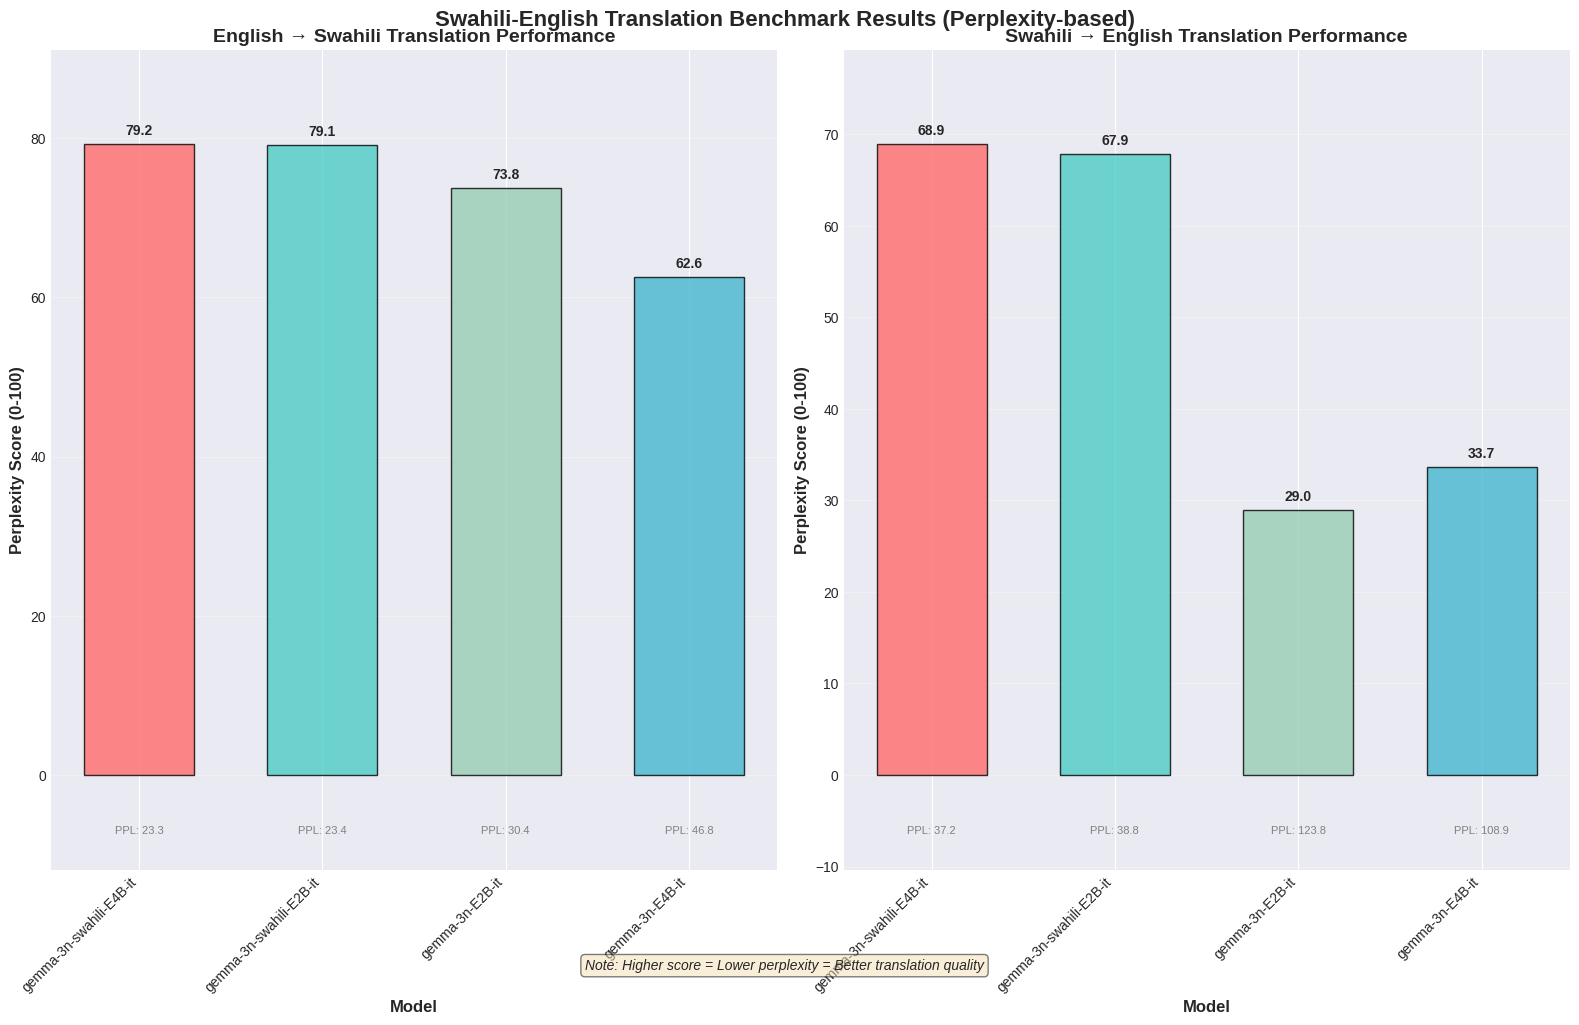

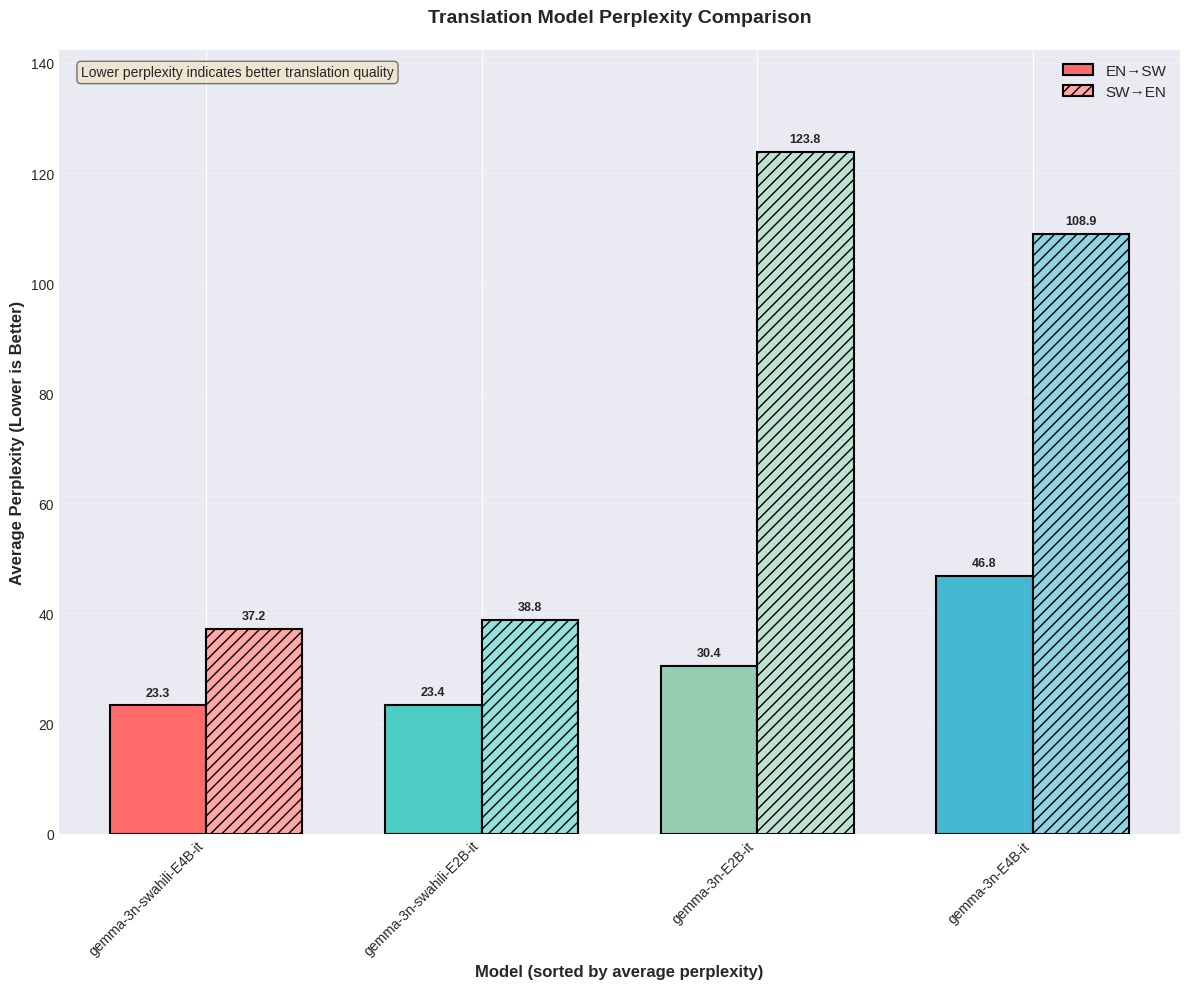

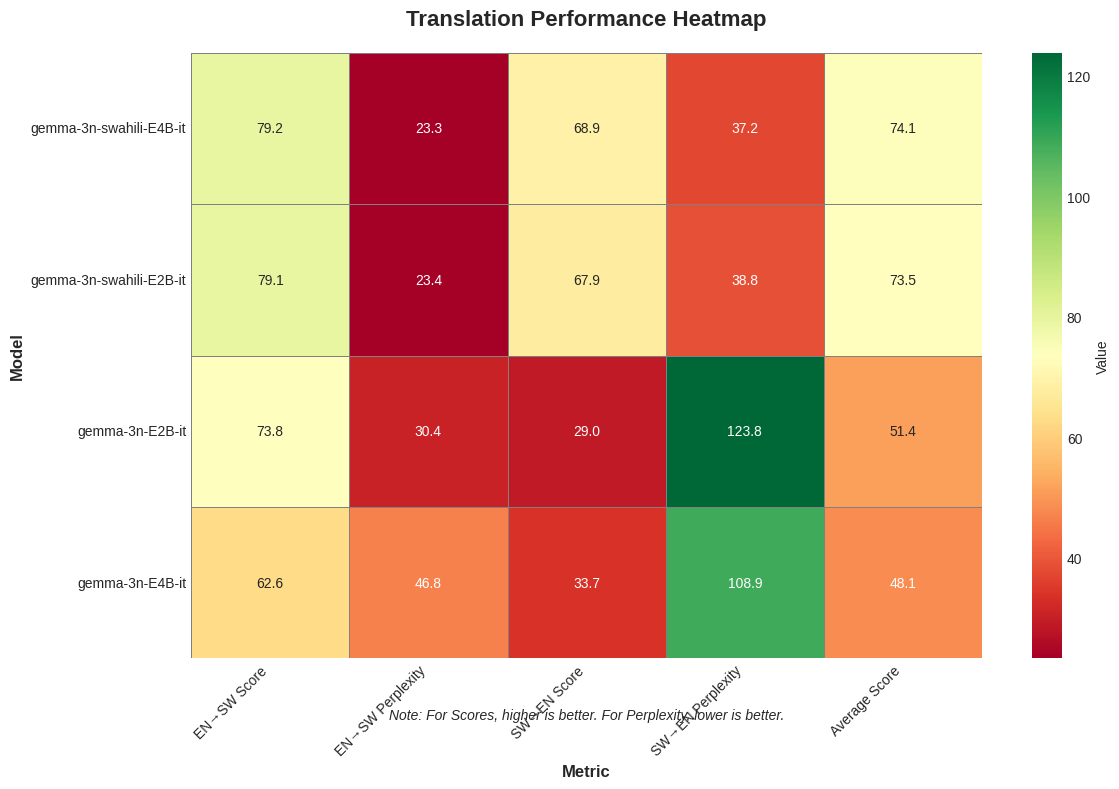

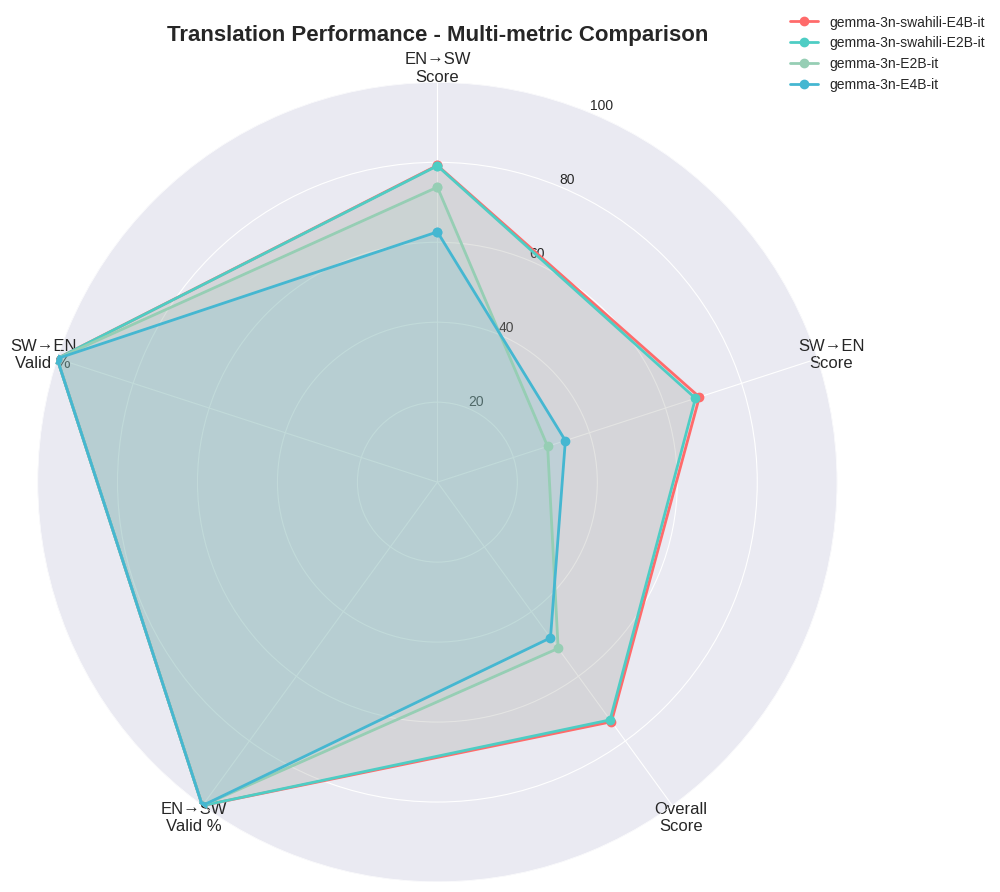

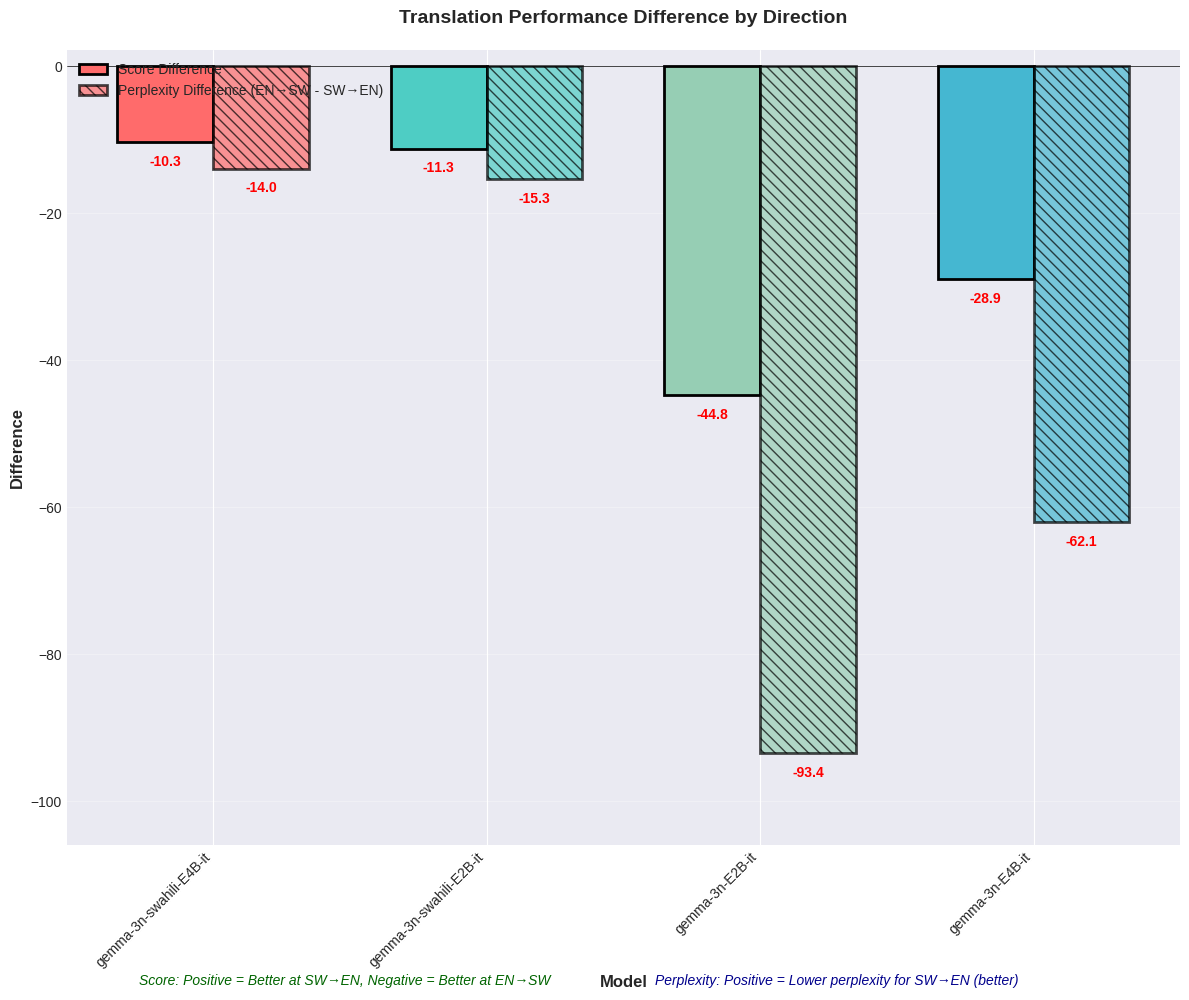


SWAHILI-ENGLISH TRANSLATION BENCHMARK - SUMMARY STATISTICS (Perplexity-based)
Model                          Avg Score    Avg PPL      EN→SW PPL    SW→EN PPL   
----------------------------------------------------------------------------------------------------
gemma-3n-swahili-E4B-it            74.1        30.3        23.3        37.2
gemma-3n-swahili-E2B-it            73.5        31.1        23.4        38.8
gemma-3n-E2B-it                    51.4        77.1        30.4       123.8
gemma-3n-E4B-it                    48.1        77.9        46.8       108.9

Note: Lower perplexity (PPL) indicates better translation quality
Score is normalized (0-100) where higher is better

All visualizations saved to 'plots/translation/' directory
Summary statistics saved to 'results/translation/translation_summary_statistics.json'

📝 Example analysis from best model (gemma-3n-swahili-E4B-it):

EN→SW - Best example (lowest perplexity):
  Source: Because this is one of the young of the species.
  Re

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Load results
with open('results/translation/all_models_translation_results.json', 'r', encoding='utf-8') as f:
    all_results = json.load(f)

# Sort models by overall score (higher is better)
sorted_models = sorted(all_results.items(),
                      key=lambda x: x[1]['overall']['avg_score'],
                      reverse=True)

# Define distinctive colors for each model (same as MMLU)
colors = {
    'gemma-3n-swahili-E4B-it': '#FF6B6B',  # Vibrant Red
    'gemma-3n-swahili-E2B-it': '#4ECDC4',  # Turquoise
    'gemma-3n-E4B-it': '#45B7D1',          # Sky Blue
    'gemma-3n-E2B-it': '#96CEB4'           # Mint Green
}

# 1. Overall Performance Comparison (EN→SW and SW→EN side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))  # Increased height

model_names = [m[0] for m in sorted_models]
model_colors = [colors.get(name, '#666666') for name in model_names]

# EN→SW subplot - using perplexity scores
en_sw_scores = [m[1]['en_to_sw']['perplexity_score'] for m in sorted_models]
en_sw_perplexity = [m[1]['en_to_sw']['avg_perplexity'] for m in sorted_models]

x = np.arange(len(model_names))
width = 0.6

bars1 = ax1.bar(x, en_sw_scores, width,
                 color=model_colors, alpha=0.8, edgecolor='black', linewidth=1)

# Find max score for positioning
max_score1 = max(en_sw_scores)

# Add value labels and perplexity values with better spacing
for i, (bar, score, perp) in enumerate(zip(bars1, en_sw_scores, en_sw_perplexity)):
    height = bar.get_height()
    # Score label above bar
    ax1.text(bar.get_x() + bar.get_width()/2., height + max_score1 * 0.01,
            f'{score:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Perplexity label below x-axis
    ax1.text(bar.get_x() + bar.get_width()/2., -max_score1 * 0.08,
            f'PPL: {perp:.1f}', ha='center', va='top', fontsize=8, color='gray')

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Perplexity Score (0-100)', fontsize=12, fontweight='bold')
ax1.set_title('English → Swahili Translation Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_ylim(-max_score1 * 0.15, max_score1 * 1.15)  # Add space for labels
ax1.grid(axis='y', alpha=0.3)

# SW→EN subplot
sw_en_scores = [m[1]['sw_to_en']['perplexity_score'] for m in sorted_models]
sw_en_perplexity = [m[1]['sw_to_en']['avg_perplexity'] for m in sorted_models]

bars2 = ax2.bar(x, sw_en_scores, width,
                 color=model_colors, alpha=0.8, edgecolor='black', linewidth=1)

# Find max score for positioning
max_score2 = max(sw_en_scores)

# Add value labels and perplexity values with better spacing
for i, (bar, score, perp) in enumerate(zip(bars2, sw_en_scores, sw_en_perplexity)):
    height = bar.get_height()
    # Score label above bar
    ax2.text(bar.get_x() + bar.get_width()/2., height + max_score2 * 0.01,
            f'{score:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Perplexity label below x-axis
    ax2.text(bar.get_x() + bar.get_width()/2., -max_score2 * 0.08,
            f'PPL: {perp:.1f}', ha='center', va='top', fontsize=8, color='gray')

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Perplexity Score (0-100)', fontsize=12, fontweight='bold')
ax2.set_title('Swahili → English Translation Performance', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylim(-max_score2 * 0.15, max_score2 * 1.15)  # Add space for labels
ax2.grid(axis='y', alpha=0.3)

# Add note as figure text at the bottom
fig.suptitle('Swahili-English Translation Benchmark Results (Perplexity-based)',
             fontsize=16, fontweight='bold', y=0.98)  # Positioned higher to avoid overlap
fig.text(0.5, 0.02, 'Note: Higher score = Lower perplexity = Better translation quality',
         ha='center', fontsize=10, style='italic',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.94)  # Adjusted top margin to prevent title overlap
plt.savefig('plots/translation/translation_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Perplexity Comparison Plot - UPDATED WITH DISTINCTIVE COLORS
fig, ax = plt.subplots(figsize=(12, 10))  # Increased height for better spacing

# Sort by average perplexity (lower is better)
sorted_by_perplexity = sorted(all_results.items(),
                              key=lambda x: x[1]['overall']['avg_perplexity'])

model_names_perp = [m[0] for m in sorted_by_perplexity]

# Define distinctive colors for EN→SW (darker/solid) and SW→EN (lighter/pattern)
# Using different shades and patterns for each direction
en_sw_colors = []
sw_en_colors = []
for name in model_names_perp:
    base_color = colors.get(name, '#666666')
    en_sw_colors.append(base_color)
    # Create a lighter version for SW→EN
    # Convert hex to RGB, lighten, then back to hex
    rgb = tuple(int(base_color[i:i+2], 16) for i in (1, 3, 5))
    lighter_rgb = tuple(min(255, int(c + (255-c)*0.4)) for c in rgb)
    sw_en_colors.append('#{:02x}{:02x}{:02x}'.format(*lighter_rgb))

# Prepare data
en_sw_perp = [m[1]['en_to_sw']['avg_perplexity'] for m in sorted_by_perplexity]
sw_en_perp = [m[1]['sw_to_en']['avg_perplexity'] for m in sorted_by_perplexity]

x = np.arange(len(model_names_perp))
width = 0.35

# Create bars with distinctive colors and patterns
bars1 = ax.bar(x - width/2, en_sw_perp, width, label='EN→SW',
                color=en_sw_colors, alpha=1.0, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, sw_en_perp, width, label='SW→EN',
                color=sw_en_colors, alpha=1.0, edgecolor='black', linewidth=1.5,
                hatch='///')  # Add pattern to distinguish

# Find the maximum bar height to position labels properly
max_height = max(max(en_sw_perp), max(sw_en_perp))

# Add value labels with better spacing
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model (sorted by average perplexity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Perplexity (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Translation Model Perplexity Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names_perp, rotation=45, ha='right')
ax.set_ylim(0, max_height * 1.15)  # Add 15% space at top for labels
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add note in the upper left of the plot
ax.text(0.02, 0.98, 'Lower perplexity indicates better translation quality',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plots/translation/translation_perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Combined Performance Heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
metrics = ['EN→SW Score', 'EN→SW Perplexity', 'SW→EN Score', 'SW→EN Perplexity', 'Average Score']
heatmap_data = []

for model_name, _ in sorted_models:
    model_scores = []
    model_scores.append(all_results[model_name]['en_to_sw']['perplexity_score'])
    model_scores.append(all_results[model_name]['en_to_sw']['avg_perplexity'])
    model_scores.append(all_results[model_name]['sw_to_en']['perplexity_score'])
    model_scores.append(all_results[model_name]['sw_to_en']['avg_perplexity'])
    model_scores.append(all_results[model_name]['overall']['avg_score'])
    heatmap_data.append(model_scores)

heatmap_data = np.array(heatmap_data)

# Create two colormaps - one for scores (higher better) and one for perplexity (lower better)
# For visualization, we'll normalize the perplexity columns
perp_cols = [1, 3]  # Perplexity columns
score_cols = [0, 2, 4]  # Score columns

# Create normalized data for visualization
viz_data = heatmap_data.copy()
# Invert perplexity values for consistent color interpretation
max_perp = viz_data[:, perp_cols].max()
for col in perp_cols:
    viz_data[:, col] = max_perp - viz_data[:, col]

# Create heatmap
cmap = sns.color_palette("RdYlGn", as_cmap=True)
ax = sns.heatmap(heatmap_data,
                 xticklabels=metrics,
                 yticklabels=model_names,
                 annot=True,
                 fmt='.1f',
                 cmap=cmap,
                 cbar_kws={'label': 'Value'},
                 linewidths=0.5,
                 linecolor='gray')

# Add text to explain the metrics
ax.text(0.5, -0.1, 'Note: For Scores, higher is better. For Perplexity, lower is better.',
        transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.title('Translation Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/translation/translation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Radar Chart for Multi-metric Comparison
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Metrics for radar chart
radar_metrics = ['EN→SW\nScore', 'SW→EN\nScore', 'Overall\nScore', 'EN→SW\nValid %', 'SW→EN\nValid %']
num_vars = len(radar_metrics)

# Compute angle for each metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot each model
for model_name, _ in sorted_models:
    values = [
        all_results[model_name]['en_to_sw']['perplexity_score'],
        all_results[model_name]['sw_to_en']['perplexity_score'],
        all_results[model_name]['overall']['avg_score'],
        (all_results[model_name]['en_to_sw']['valid_examples'] /
         all_results[model_name]['en_to_sw']['num_examples']) * 100,
        (all_results[model_name]['sw_to_en']['valid_examples'] /
         all_results[model_name]['sw_to_en']['num_examples']) * 100
    ]
    values += values[:1]  # Complete the circle

    ax.plot(angles, values, 'o-', linewidth=2,
            label=model_name, color=colors.get(model_name, '#666666'))
    ax.fill(angles, values, alpha=0.15, color=colors.get(model_name, '#666666'))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title('Translation Performance - Multi-metric Comparison',
          fontsize=16, fontweight='bold', pad=30)
plt.tight_layout()
plt.savefig('plots/translation/translation_radar.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Performance Difference Plot (SW→EN vs EN→SW) - UPDATED WITH DISTINCTIVE COLORS
fig, ax = plt.subplots(figsize=(12, 10))  # Increased height for better spacing

# Calculate score differences
score_diffs = [all_results[m]['sw_to_en']['perplexity_score'] - all_results[m]['en_to_sw']['perplexity_score']
               for m, _ in sorted_models]
perp_diffs = [all_results[m]['en_to_sw']['avg_perplexity'] - all_results[m]['sw_to_en']['avg_perplexity']
              for m, _ in sorted_models]

x = np.arange(len(model_names))
width = 0.35

# Create bars with different styles for each metric
bars1 = ax.bar(x - width/2, score_diffs, width, label='Score Difference',
                color=model_colors, alpha=1.0, edgecolor='black', linewidth=2)
# Use hatching pattern for perplexity difference bars
bars2 = ax.bar(x + width/2, perp_diffs, width, label='Perplexity Difference (EN→SW - SW→EN)',
                color=model_colors, alpha=0.7, edgecolor='black', linewidth=2,
                hatch='\\\\\\')

# Find min and max values for proper spacing
all_values = score_diffs + perp_diffs
min_val = min(all_values)
max_val = max(all_values)
y_range = max_val - min_val

# Add value labels with better spacing
for bars, diffs in [(bars1, score_diffs), (bars2, perp_diffs)]:
    for bar, diff in zip(bars, diffs):
        height = bar.get_height()
        color = 'green' if height > 0 else 'red'
        # Adjust label position based on bar height
        label_offset = y_range * 0.02  # 2% of the y-range
        ax.text(bar.get_x() + bar.get_width()/2.,
                height + label_offset if height > 0 else height - label_offset,
                f'{height:.1f}', ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=10, color=color, fontweight='bold')

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Difference', fontsize=12, fontweight='bold')
ax.set_title('Translation Performance Difference by Direction', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(min_val - y_range * 0.15, max_val + y_range * 0.15)  # Add 15% padding
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add explanatory text at the bottom of the figure
fig.text(0.12, 0.01, 'Score: Positive = Better at SW→EN, Negative = Better at EN→SW',
         fontsize=10, color='darkgreen', style='italic')
fig.text(0.55, 0.01, 'Perplexity: Positive = Lower perplexity for SW→EN (better)',
         fontsize=10, color='darkblue', style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the explanatory text
plt.savefig('plots/translation/translation_direction_difference.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Summary Statistics Table
print("\n" + "="*100)
print("SWAHILI-ENGLISH TRANSLATION BENCHMARK - SUMMARY STATISTICS (Perplexity-based)")
print("="*100)
print(f"{'Model':<30} {'Avg Score':<12} {'Avg PPL':<12} {'EN→SW PPL':<12} {'SW→EN PPL':<12}")
print("-"*100)

for model_name, result in sorted_models:
    avg_score = result['overall']['avg_score']
    avg_ppl = result['overall']['avg_perplexity']
    en_sw_ppl = result['en_to_sw']['avg_perplexity']
    sw_en_ppl = result['sw_to_en']['avg_perplexity']

    print(f"{model_name:<30} {avg_score:>8.1f}    {avg_ppl:>8.1f}    "
          f"{en_sw_ppl:>8.1f}    {sw_en_ppl:>8.1f}")

print("="*100)
print("\nNote: Lower perplexity (PPL) indicates better translation quality")
print("Score is normalized (0-100) where higher is better")

# Save summary statistics
summary_stats = {
    'evaluation_summary': {
        'total_models': len(all_results),
        'total_en_to_sw_examples': sorted_models[0][1]['en_to_sw']['num_examples'],
        'total_sw_to_en_examples': sorted_models[0][1]['sw_to_en']['num_examples'],
        'evaluation_date': sorted_models[0][1]['timestamp'].split('T')[0],
        'evaluation_method': 'perplexity-based'
    },
    'model_rankings': [
        {
            'rank': i+1,
            'model': model_name,
            'avg_score': result['overall']['avg_score'],
            'avg_perplexity': result['overall']['avg_perplexity'],
            'en_to_sw_perplexity': result['en_to_sw']['avg_perplexity'],
            'sw_to_en_perplexity': result['sw_to_en']['avg_perplexity']
        }
        for i, (model_name, result) in enumerate(sorted_models)
    ],
    'direction_comparison': {
        model: {
            'better_direction': 'SW→EN' if all_results[model]['sw_to_en']['avg_perplexity'] < all_results[model]['en_to_sw']['avg_perplexity'] else 'EN→SW',
            'perplexity_difference': all_results[model]['en_to_sw']['avg_perplexity'] - all_results[model]['sw_to_en']['avg_perplexity']
        }
        for model in all_results
    }
}

with open('results/translation/translation_summary_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print(f"\nAll visualizations saved to 'plots/translation/' directory")
print(f"Summary statistics saved to 'results/translation/translation_summary_statistics.json'")

# Print best/worst examples for the best model
best_model = sorted_models[0][0]
print(f"\n📝 Example analysis from best model ({best_model}):")

if all_results[best_model]['en_to_sw']['example_translations']:
    print("\nEN→SW - Best example (lowest perplexity):")
    best_ex = all_results[best_model]['en_to_sw']['example_translations'][0]
    print(f"  Source: {best_ex['source']}")
    print(f"  Reference: {best_ex['reference']}")
    print(f"  Perplexity: {best_ex['perplexity']:.2f}")

    if len(all_results[best_model]['en_to_sw']['example_translations']) > 1:
        print("\nEN→SW - Worst example (highest perplexity):")
        worst_ex = all_results[best_model]['en_to_sw']['example_translations'][1]
        print(f"  Source: {worst_ex['source']}")
        print(f"  Reference: {worst_ex['reference']}")
        print(f"  Perplexity: {worst_ex['perplexity']:.2f}")

if all_results[best_model]['sw_to_en']['example_translations']:
    print("\nSW→EN - Best example (lowest perplexity):")
    best_ex = all_results[best_model]['sw_to_en']['example_translations'][0]
    print(f"  Source: {best_ex['source']}")
    print(f"  Reference: {best_ex['reference']}")
    print(f"  Perplexity: {best_ex['perplexity']:.2f}")

    if len(all_results[best_model]['sw_to_en']['example_translations']) > 1:
        print("\nSW→EN - Worst example (highest perplexity):")
        worst_ex = all_results[best_model]['sw_to_en']['example_translations'][1]
        print(f"  Source: {worst_ex['source']}")
        print(f"  Reference: {worst_ex['reference']}")
        print(f"  Perplexity: {worst_ex['perplexity']:.2f}")